In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate
#pip install jiwer

from jiwer import cer



def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

c:\Users\cyrine.anene_amaris\Documents\whisper_fine_tuned\Fine-tuning-Whisper-Air-Traffic-Control\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='bengali',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='bengali',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

#### Verify if the tokenizer supports the target language

In [6]:
arabic_text = 'اهلا كيف الحال؟'

tokenized_text = tokenizer(arabic_text)

tokenizer.decode(tokenized_text.input_ids)

'<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>اهلا كيف الحال؟<|endoftext|>'

This means that the tokenizer supports the arabic language.

In [9]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
from dotenv import load_dotenv
from huggingface_hub import HfFolder

load_dotenv()
hf_token = os.getenv("HF_TOKEN")
HfFolder.save_token(hf_token)


In [13]:
from datasets import load_dataset,concatenate_datasets

cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split=["train", "test"], trust_remote_code=True)

Reading metadata...: 28369it [00:00, 147717.67it/s]es/s]
Generating train split: 28369 examples [00:11, 2491.55 examples/s]
Reading metadata...: 10470it [00:00, 180675.16it/s]xamples/s]
Generating validation split: 10470 examples [00:02, 3801.78 examples/s]
Reading metadata...: 10480it [00:00, 186053.71it/s]s/s]
Generating test split: 10480 examples [00:02, 3858.08 examples/s]
Reading metadata...: 41628it [00:00, 162945.33it/s]es/s]
Generating other split: 41628 examples [00:15, 2665.71 examples/s]
Reading metadata...: 15108it [00:00, 167610.19it/s]examples/s]
Generating invalidated split: 15108 examples [00:16, 909.09 examples/s] 
Reading metadata...: 78156it [00:00, 192605.78it/s]amples/s]
Generating validated split: 78156 examples [00:33, 2354.58 examples/s]


In [16]:
train_data = concatenate_datasets([cv_17[0],cv_17[1]])
print(train_data)
test_data = cv_17[1]
print(test_data)

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 38849
})
Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 10480
})


In [17]:
train_data[0]

{'client_id': '4423514fa51943a7a32bbed365f479687b108270c71c3b0691032ccbe7073cad303e3a9d84817c1b5b230d0531827b87a9e384b98fa2ccf8d892232e98b00f9b',
 'path': 'C:\\Users\\cyrine.anene_amaris\\.cache\\huggingface\\datasets\\downloads\\extracted\\5725af6a6738d7803239449cb9608814f99d651181f318ddc45d6c27ac15a668\\ar_train_0/common_voice_ar_24032301.mp3',
 'audio': {'path': 'C:\\Users\\cyrine.anene_amaris\\.cache\\huggingface\\datasets\\downloads\\extracted\\5725af6a6738d7803239449cb9608814f99d651181f318ddc45d6c27ac15a668\\ar_train_0/common_voice_ar_24032301.mp3',
  'array': array([1.13686838e-13, 7.95807864e-13, 1.10844667e-12, ...,
         1.49943362e-05, 2.72979014e-05, 1.81282685e-05], shape=(247104,)),
  'sampling_rate': 48000},
 'sentence': 'وما كان ربك ليهلك القرى بظلم وأهلها مصلحون',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'ar',
 'segment': '',
 'variant': ''}

In [18]:
text = train_data[0]['sentence']
tok_sentence = tokenizer(text)
tok_sentence

{'input_ids': [50258, 50302, 50359, 50363, 2407, 15042, 25961, 12602, 3555, 4117, 32239, 3224, 23275, 25062, 2288, 7578, 4724, 19913, 19528, 36725, 3224, 1211, 11296, 3714, 36520, 5016, 11536, 50257], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
from IPython.display import clear_output
import time

for idx in range(len(tok_sentence.input_ids)):
    print(tokenizer.decode(tok_sentence.input_ids[:idx]))
    clear_output(wait=True)
    time.sleep(.1)

<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>وما كان ربك ليهلك القرى بظلم وأهلها مصلحون


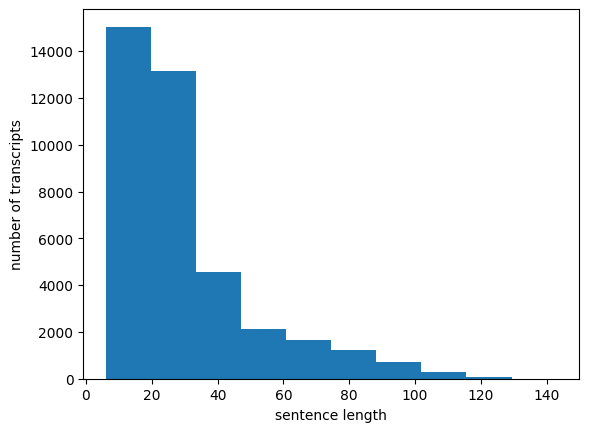

In [21]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(train_data['sentence']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [23]:
import torch

for idx in range(5):

    target = train_data[idx]['sentence']
    audio_original = train_data[idx]['audio']['array']
    original_sample_rate = train_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='arabic', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : وما كان ربك ليهلك القرى بظلم وأهلها مصلحون 
pred :  وما كان رب كليف لك القراب دون مو أهلوام سلحون

 
-------1------
true : أقدر تعاونك معنا. 
pred :  أقدر تعاونك معنا

 
-------2------
true : وَلُوطًا إِذْ قَالَ لِقَوْمِهِ أَتَأْتُونَ الْفَاحِشَةَ مَا سَبَقَكُمْ بِهَا مِنْ أَحَدٍ مِنَ الْعَالَمِينَ 
pred :  والوطن اتقال لقومه اتأتون الفاحشة ما سبقكم بها من احد من العالمين

 
-------3------
true : فلما رأوا بأسنا قالوا آمنا بالله وحده وكفرنا بما كنا به مشركين 
pred :  فلما رأوا بأسنا قالوا أاملنا بالله وحده وكفرنا بما كنا به مش إكيم

 
-------4------
true : لمن هذا الكتاب؟ 
pred :  دي منحل الكتاب

 


In [25]:
class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["sentence"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [26]:
dataset = whisper_training_dataset(dataset=train_data, max_len=300)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [30]:
def evaluation(model):

    device='cuda'

    test_dataset = whisper_training_dataset(dataset=test_data, max_len=300)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,  # Adjust batch size as needed
        shuffle=True,  # Shuffle data during training
    )

    model.eval()

    predictions=[]
    references=[]

    for batch in tqdm(test_dataloader,total=len(test_dataloader)):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features,language='arabic', task='transcribe')
                        
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER

In [ ]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

In [ ]:
from IPython.display import clear_output
torch.cuda.empty_cache()

model.train()

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)
# optimizer=torch.optim.AdamW(requires_grad_params, lr=5e-4) # Only for LoRA Training

max_epochs=2


running_wer=[]
running_loss=[]



for epoch in range(max_epochs):

    for batch in tqdm(train_dataloader,total=len(train_dataloader),leave=False):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

        running_loss.append(loss.item())

        if len(running_loss) % 50 ==0:  # Print loss every 50 batches
            plt.plot(running_loss)
            plt.xlabel('steps')
            plt.ylabel('loss')
            clear_output(wait=True)  # Clear the output to keep the plot clean
            plt.show()

        if len(running_loss) % 100 == 0:  # Save model every 100 steps
            # torch.save(model.state_dict(), f'finetuned_on_odia_steps_{len(running_loss)}.pth')
            model.save_pretrained('lora_model')

    torch.cuda.empty_cache()
    running_wer.append(evaluation(model))

In [ ]:
model.load_state_dict(torch.load('finetuned_on_odia_steps_1000.pth', weights_only=True))# loading the model
model.eval()
model.to('cuda')


torch.cuda.empty_cache()
evaluation(model)

In [ ]:
model.eval()

test_data = load_dataset("mozilla-foundation/common_voice_17_0", "ar", split="test")

for idx in range(5):

    target = test_data[idx]['sentence']
    audio_original = test_data[idx]['audio']['array']
    original_sample_rate = test_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='arabic', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')